# Starting Kit - FAIR UNIVERSE: HIGGSML UNCERTAINTY CHALLENGE

For Overview and Decsiptions of the competition, please visit the competition page

## Setup
`COLAB` determines whether this notebook is running on Google Colab.

In [1]:
COLAB = 'google.colab' in str(get_ipython())

In [2]:
if COLAB:
    # clone github repo
    !git clone https://github.com/FAIR-Universe/HEP-Challenge.git
    !pip install iminuit

    # move to the HEP starting kit folder
    %cd HEP-Challenge/

In [3]:
TEST_SETTINGS = {
"systematics": {  # Systematics to use
    "tes": True, # tau energy scale
    "jes": False, # jet energy scale
    "soft_met": False, # soft term in MET
    "ttbar_scale": False, # ttbar scale factor
    "diboson_scale": False, # diboson scale factor
    "bkg_scale": False, # Background scale factor
    },
"num_pseudo_experiments" : 2 , # Number of pseudo-experiments to run per set
"num_of_sets" : 5, # Number of sets of pseudo-experiments to run
} 

USE_RANDOM_MUS = True

## Existing Submissions
By this point you should have a clone of the repo which contains `HiggsML_Dummy_Submission.zip` which you can submit to the Competition

For more sample submissions please check `/HEP-Challenge/example_submissions/`

### Imports

In [4]:
from sys import path
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from itertools import product
from numpy.random import RandomState
import warnings
import os
import sys
warnings.filterwarnings("ignore")

### Directories

In [5]:

root_dir = os.getcwd()
print("Root directory is", root_dir)

input_dir = os.path.join("/data/atlas/chakkappai/FairUniverse/Full_combined_dataset_05_08_2024_no_der/challenge_data", "input_data")
output_dir = os.path.join(root_dir, "sample_result_submission")
submission_dir = os.path.join(root_dir, "sample_code_submission")
program_dir = os.path.join(root_dir, "ingestion_program")
score_dir = os.path.join(root_dir, "scoring_program")
    
test_settings = TEST_SETTINGS.copy()

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
if USE_RANDOM_MUS:
    test_settings[ "ground_truth_mus"] = (np.random.uniform(0.1, 3, test_settings["num_of_sets"])).tolist()
    
    random_settings_file = os.path.join(output_dir, "random_mu.json")
    with open(random_settings_file, "w") as f:
        json.dump(test_settings, f)
else:
    test_settings_file = os.path.join(input_dir, "test", "settings", "data.json")
    with open(test_settings_file) as f:
        test_settings = json.load(f)


Root directory is /data/atlas/chakkappai/FairUniverse/HEP-Challenge



### Add directories to path

In [6]:
path.append(program_dir)
path.append(submission_dir)
path.append(score_dir)

***
# Internal imports
***

In [7]:
from visualization import *
from systematics import systematics

***
# Import Submission Model
***
We import a class named `Model` from the submission file (`model.py`). This `Model` class has the following methods:
- `init`: receives train set and systematics class as input
- `fit`: can be used for training
- `predict`: receives one test set and outputs a dictionary with the following keys
    - `mu_hat` : predicted mu $\hat{\mu}$
    - `delta_mu_hat`: $\Delta{\hat{\mu}}$ bound for $\mu$
    - `p16`: 16th percentile
    - `p84`: 84th percentile

In this example code, the `Model` class implements an XGBoost model which is trained to predict both the TES and the class label. You can find the code in `HEP-Challenge/sample_code_submission/model.py`. You can modify it the way you want, keeping the required class structure and functions there. More instructions are given inside the `model.py` file. If running in Collab, click the folder icon in the left sidebar to open the file browser.

### ⚠️ Note:
In real setting i.e. the challenge itself, the submitted model is initialized once with train set and systematics class and the `predict` is called multiple times, each time with a different test sets. 

In [8]:
from model import Model
from datasets import Data

***
## Data
***

### ⚠️ Note:
The data used here is a small sample data is for demonstration only to get a view of what the data looks like. 

`USE_PUBLIC_DATASET` determines whether to use a public dataset provided for the participants or use a small sample datafor quick execution of this notebook

In [9]:
USE_PUBLIC_DATASET = False

`USE_PUBLIC_DATASET` determines whether to use a public dataset provided for the participants or use a small subset of the data for quick execution of this notebook

In [10]:
if USE_PUBLIC_DATASET:
    from datasets import Neurips2024_public_dataset as public_dataset
    data = public_dataset()
else:
    data = Data(input_dir)

The function loads the downloaded data in the public_data folder or downloads the data from codabench using `wget` in the absence of the downloaded data, 

In [11]:
# load train set
data.load_train_set()

[*] Loading Train data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98678951 entries, 0 to 98678950
Columns: 16 entries, PRI_lep_pt to PRI_met_phi
dtypes: float32(16)
memory usage: 5.9 GB
None
[+] Train data loaded successfully


In [12]:
# load test sets
data.load_test_set()

[*] Loading Test data
[+] Test data loaded successfully


***
# Visualize
***
- Visualize Train set

In [13]:
data_vis = systematics(data.get_train_set())

train_visualize = Dataset_visualise(
    data_set=data_vis,
    columns=[
        "PRI_jet_leading_pt",
        "PRI_met",
        "DER_mass_vis",
        "DER_mass_jet_jet",
        "DER_sum_pt",
    ],
    name="Train Set",
)

In [14]:
# Show data summary
train_visualize.examine_dataset()

[*] --- Dataset name : Train Set
[*] --- Number of events : 86884074
[*] --- Number of features : 28
   diboson   11808.168967886804
   htautau   3322.6724157709523
   ttbar   147980.46836744243
   ztautau   3074078.236046201


[*] --- Number of signal events : 38519335
[*] --- Number of background events : 48364739
[*] --- Examples of all features


,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_had_pt,PRI_had_eta,PRI_had_phi,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,...,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_had_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_had,DER_met_phi_centrality,DER_lep_eta_centrality
0,26.509001,0.731,-0.767,34.341000,-0.735,0.968,34.341000,-0.735,0.968,30.915001,...,41.027798,1.851,94.953461,-0.820260,2.271427,42.237072,126.105995,0.771934,-0.155786,0.711012
2,33.181000,1.262,0.546,42.321999,0.854,-2.717,42.321999,0.854,-2.717,-25.000000,...,14.969712,-25.000,-25.000000,-25.000000,3.047619,53.671234,117.824997,0.784013,1.414204,-25.000000
3,24.024000,0.936,1.328,144.675995,1.464,-0.069,144.675995,1.464,-0.069,74.438004,...,130.629288,1.413,259.576050,0.074664,1.493450,201.208588,437.973022,0.166054,-0.727947,0.938161
4,43.751999,-0.656,-0.762,35.285000,-0.563,2.572,35.285000,-0.563,2.572,-25.000000,...,5.043576,-25.000,-25.000000,-25.000000,2.950651,33.865318,114.322006,1.239960,-1.412060,-25.000000
5,20.922001,-0.786,3.003,107.466003,-1.303,0.615,107.466003,-1.303,0.615,94.533997,...,84.370934,0.509,208.120087,1.034582,2.443324,96.781708,330.389008,0.194685,-1.035730,0.345122


[*] --- Description of all features


,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_had_pt,PRI_had_eta,PRI_had_phi,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,...,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_had_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_had,DER_met_phi_centrality,DER_lep_eta_centrality
count,8.688407e+07,8.688407e+07,8.688407e+07,8.688407e+07,8.688407e+07,8.688407e+07,8.688407e+07,8.688407e+07,8.688407e+07,8.688407e+07,...,8.688407e+07,8.688407e+07,8.688407e+07,8.688407e+07,8.688407e+07,8.688407e+07,8.688407e+07,8.688407e+07,8.688407e+07,8.688407e+07
mean,3.508368e+01,1.256917e-04,1.293055e-04,4.620592e+01,8.759193e-06,1.620553e-04,6.205464e+01,-6.176980e-05,-3.842171e-05,1.231452e+01,...,4.725427e+01,-1.203494e+01,9.489558e+01,-1.266179e+01,2.685672e+00,5.490521e+01,1.858100e+02,8.459183e-01,2.977047e-01,-1.269867e+01
std,1.933957e+01,1.210827e+00,1.813552e+00,2.304989e+01,1.228802e+00,1.813646e+00,4.939626e+01,1.456286e+00,1.812971e+00,4.460828e+01,...,5.997120e+01,1.340250e+01,2.278427e+02,1.286635e+01,6.424859e-01,3.507877e+01,1.340108e+02,4.991338e-01,1.202145e+00,1.268830e+01
min,2.000000e+01,-2.501000e+00,-3.142000e+00,2.600000e+01,-2.706000e+00,-3.142000e+00,2.600000e+01,-4.971000e+00,-3.142000e+00,-2.500000e+01,...,2.217959e-03,-2.500000e+01,-2.500000e+01,-2.500000e+01,4.625505e-01,1.458816e-02,7.200400e+01,1.349843e-02,-1.414214e+00,-2.500000e+01
25%,2.422300e+01,-9.360000e-01,-1.570000e+00,3.296900e+01,-9.540000e-01,-1.570000e+00,3.595000e+01,-1.073000e+00,-1.571000e+00,-2.500000e+01,...,1.157902e+01,-2.500000e+01,-2.500000e+01,-2.500000e+01,2.394881e+00,3.590673e+01,1.050200e+02,5.644209e-01,-1.302870e+00,-2.500000e+01
50%,2.966800e+01,0.000000e+00,0.000000e+00,4.044700e+01,0.000000e+00,0.000000e+00,4.567200e+01,-0.000000e+00,0.000000e+00,-2.500000e+01,...,2.378687e+01,-2.500000e+01,-2.500000e+01,-2.500000e+01,2.928166e+00,4.781107e+01,1.370720e+02,7.423114e-01,1.002846e+00,-2.500000e+01
75%,3.859200e+01,9.360000e-01,1.571000e+00,5.127600e+01,9.550000e-01,1.571000e+00,6.563600e+01,1.073000e+00,1.571000e+00,4.041700e+01,...,5.819123e+01,1.404000e+00,1.368581e+02,1.583040e-01,3.117700e+00,6.400858e+01,2.135640e+02,9.820144e-01,1.381675e+00,2.456986e-01
max,1.425160e+03,2.501000e+00,3.142000e+00,1.767040e+03,2.710000e+00,3.142000e+00,2.225930e+03,4.976000e+00,3.142000e+00,1.672120e+03,...,2.320420e+03,9.666000e+00,9.022885e+03,2.220758e+01,5.963363e+00,1.908555e+03,5.255499e+03,4.031342e+01,1.414214e+00,1.000000e+00


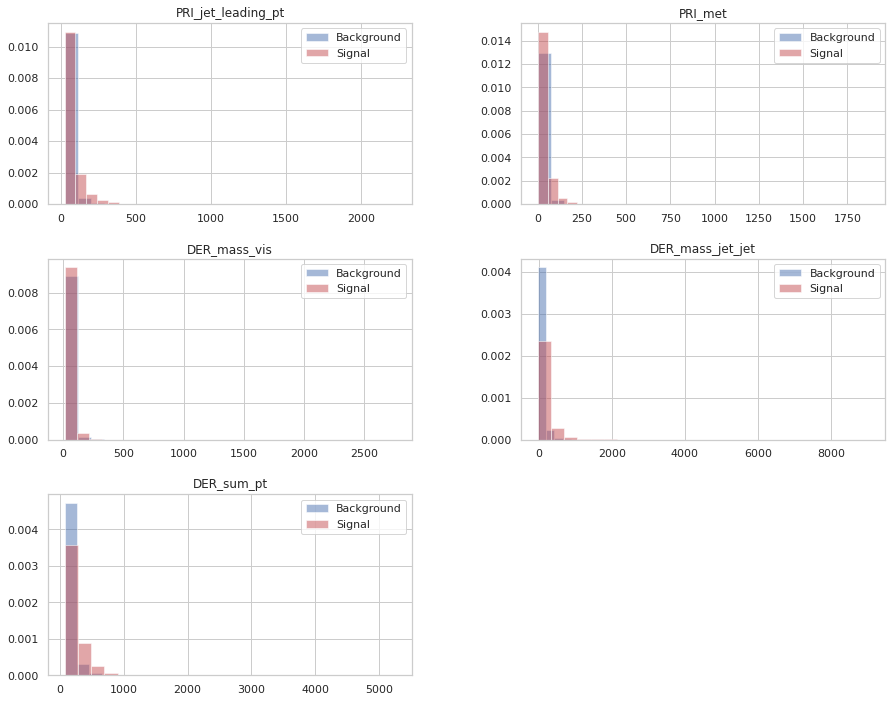

In [15]:
# Show data summary
train_visualize.histogram_dataset()

diboson (177131,)
diboson (177131,)
htautau (30,)
ttbar (2219701,)
ttbar (2219701,)
ztautau (45967907,)
ztautau (45967907,)


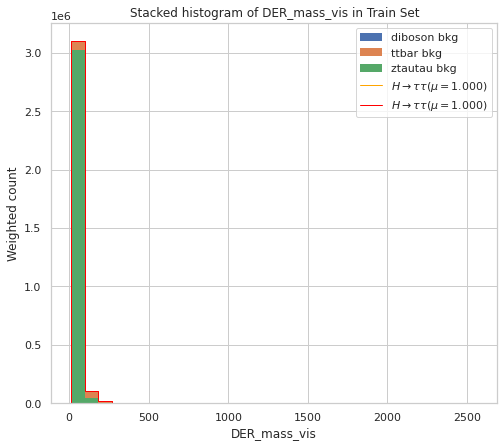

In [16]:
train_visualize.stacked_histogram("DER_mass_vis")

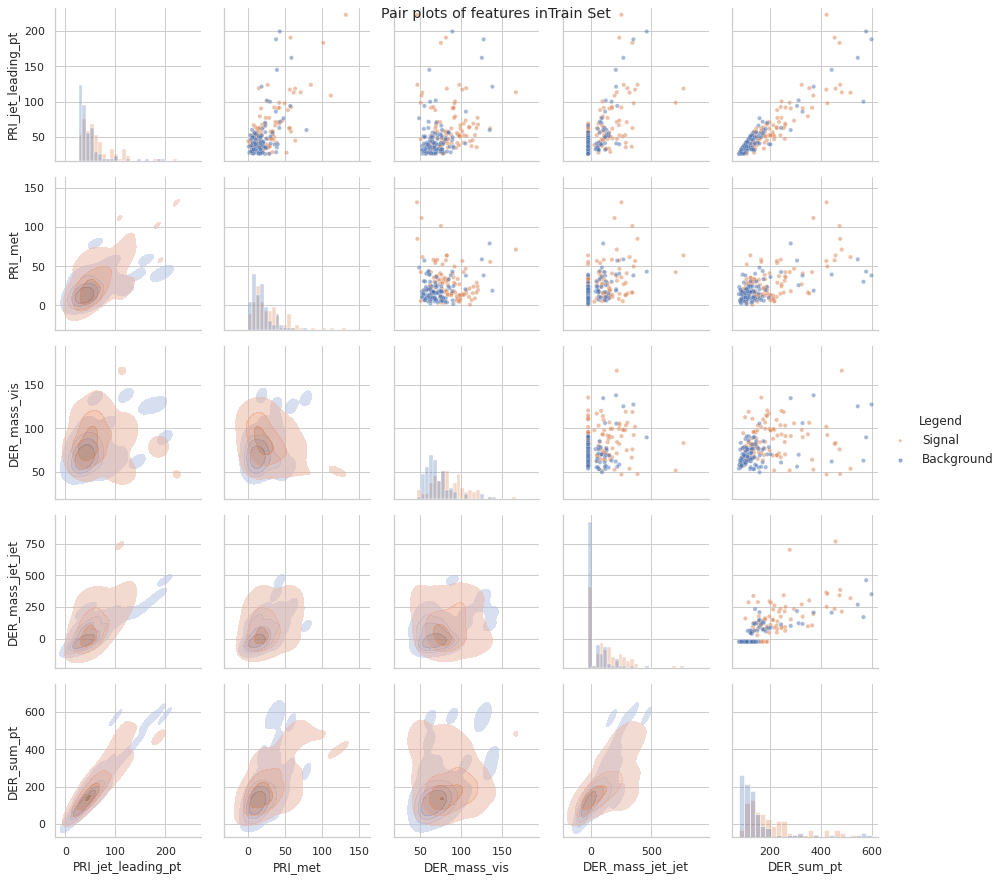

In [17]:
# Show data summary
train_visualize.pair_plots(sample_size=100)

In [18]:
syst_train_data = data.get_syst_train_set()

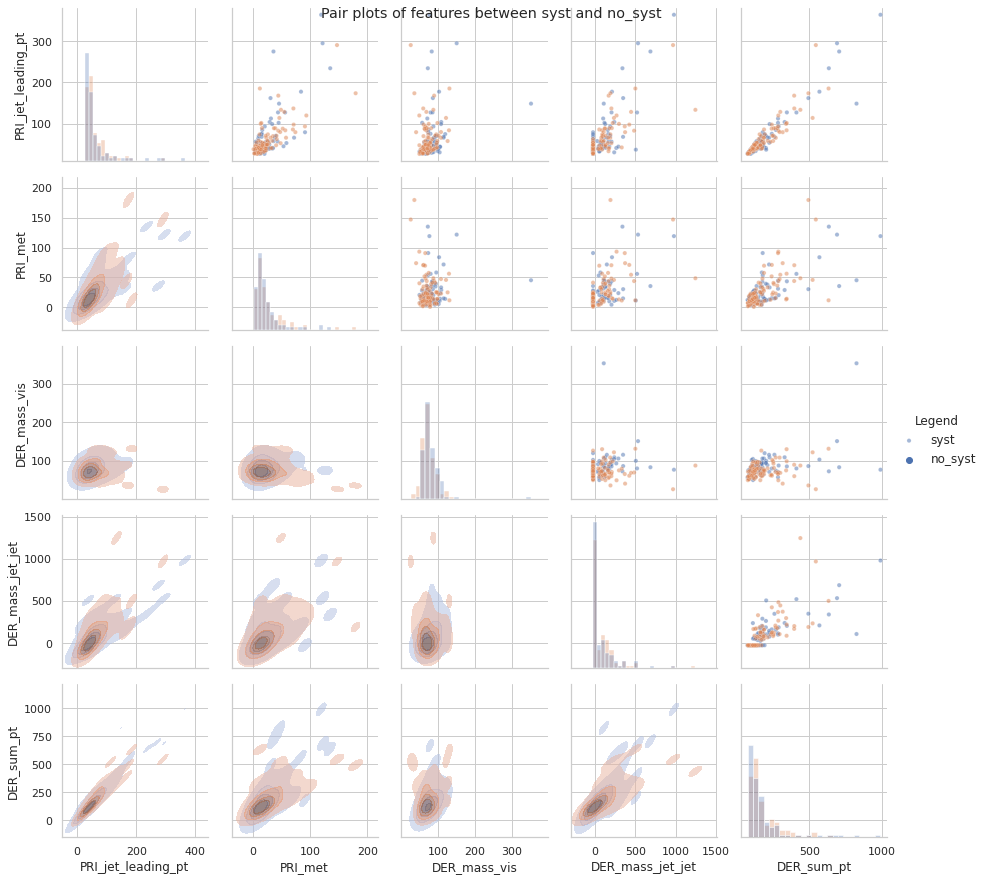

In [19]:
# Pair plots of train set with systematics
train_visualize.pair_plots_syst(syst_train_data["data"], sample_size=100)

***
### Program
***


In [22]:

from ingestion import Ingestion

ingestion = Ingestion(data)


In [23]:

# initialize submission
ingestion.init_submission(Model)

[*] Initializing Submmited Model
[*] Loading Train data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98678951 entries, 0 to 98678950
Columns: 16 entries, PRI_lep_pt to PRI_met_phi
dtypes: float32(16)
memory usage: 5.9 GB
None
[+] Train data loaded successfully
Full data:  (86884074, 28)
Full Labels:  (86884074,)
Full Weights:  (86884074,)
sum_signal_weights:  3322.6724157709523
sum_bkg_weights:  3233866.873381735
 
 
Full size of the data is 86884074
Full size of the data is 43442037
Training Set:
-------- 
  Data Shape:          (43442037, 28)
  Labels Shape:        (43442037,)
  Weights Shape:       (43442037,)
  Sum Signal Weights:  3322.67
  Sum Background Weights: 3233866.87


Validation Set:
---------- 
  Data Shape:          (21721018, 28)
  Labels Shape:        (21721018,)
  Weights Shape:       (21721018,)
  Sum Signal Weights:  3322.67
  Sum Background Weights: 3233866.87


Holdout (For Statistical Template) Set:
---------------------------------- 
  Data Shape:         

## Statistical Tools
In the process of data fitting using our ingestion module, there are two primary arguments that control how the fit is performed: stat_only and syst_settings.
- `stat_only (bool, optional)`: This argument, when set to True, forces the fitting process to compute statistics-only results. This means that only statistical uncertainties are considered, and all systematic uncertainties are ignored.
- `syst_settings (dict, optional)`: This argument is a dictionary that specifies the systematic settings, indicating whether to fix certain systematics during the fitting process. Each entry in the dictionary represents a different systematic uncertainty, with a boolean value indicating whether it should be **fixed** (True) or allowed to **float** (False).

Note that the `syst_settings` is used to only control the systematics that are allowed to float during the fitting process. It is different from the `TEST_SETTINGS['systematics']` which is used to specify the systematics to be used in the test set generation.

[*] Calling fit method of submitted model
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -4.127e+07                 │              Nfcn = 32               │
│ EDM = 3.09e-10 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬──────────

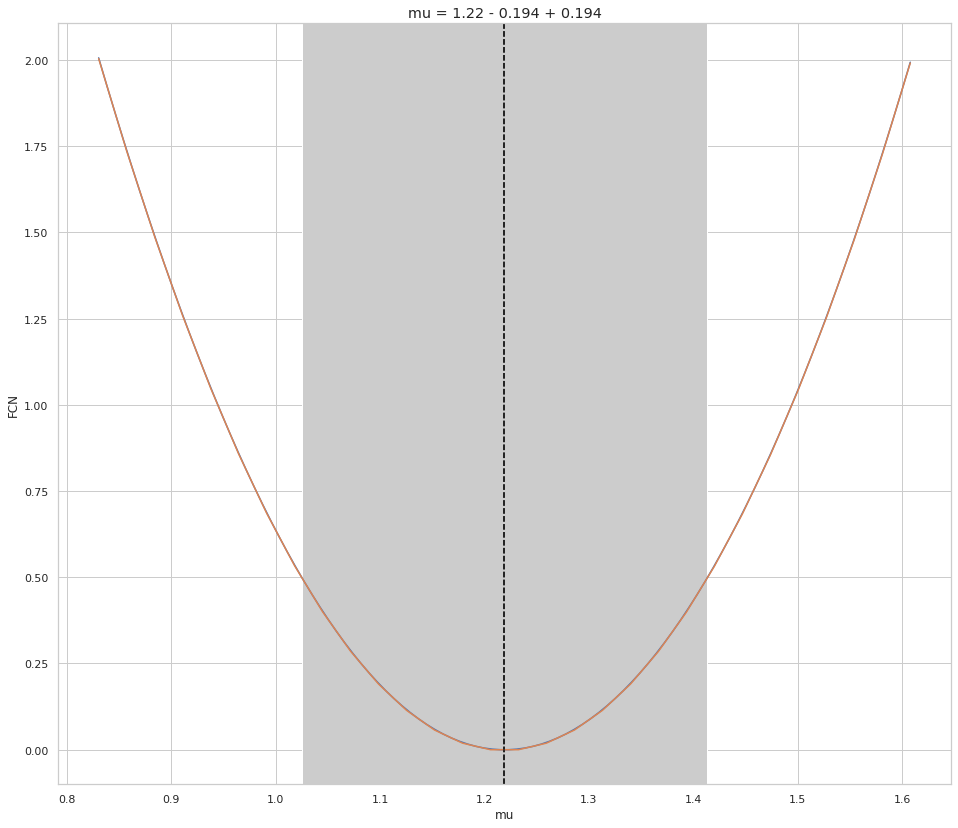

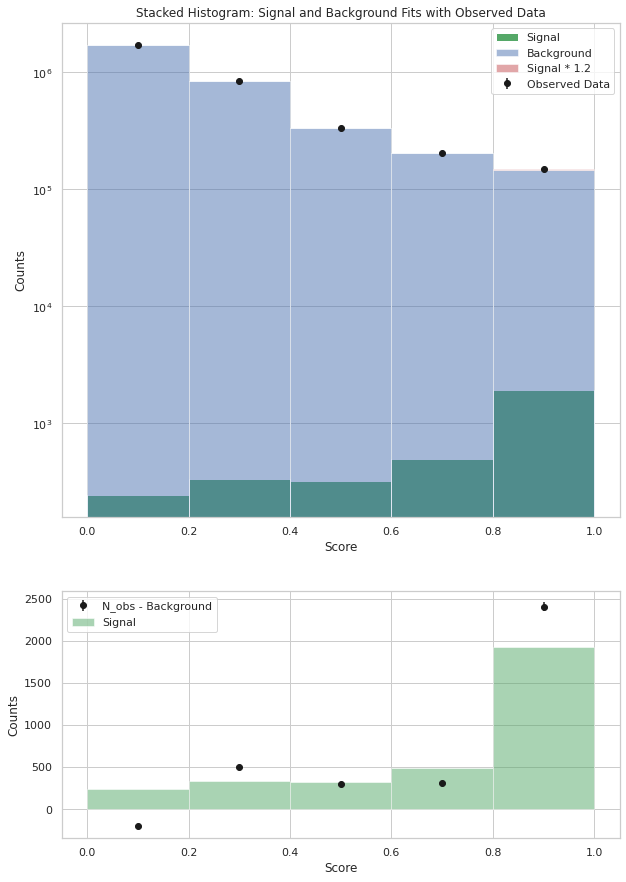

Training Results:
-------- Results:
	mu_hat : 1.219226230257967
	delta_mu_hat : 0.3886825711792988
	p16 : 1.0248849446683177
	p84 : 1.4135675158476164


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -4.127e+07                 │              Nfcn = 32               │
│ EDM = 3.34e-10 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────

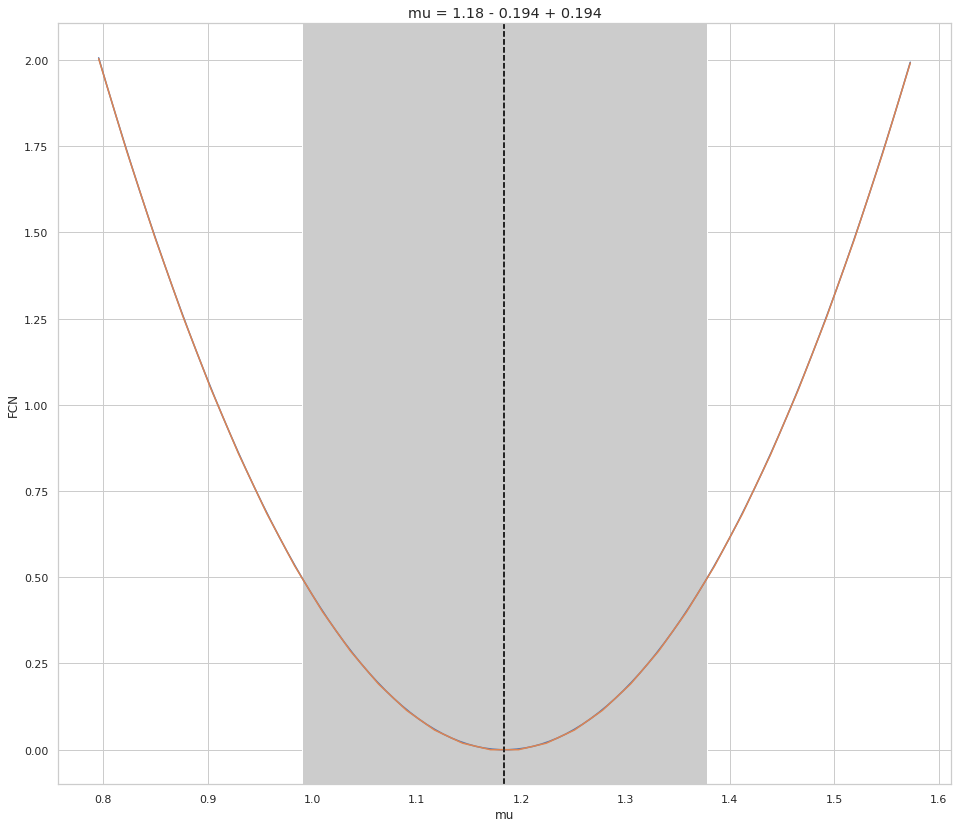

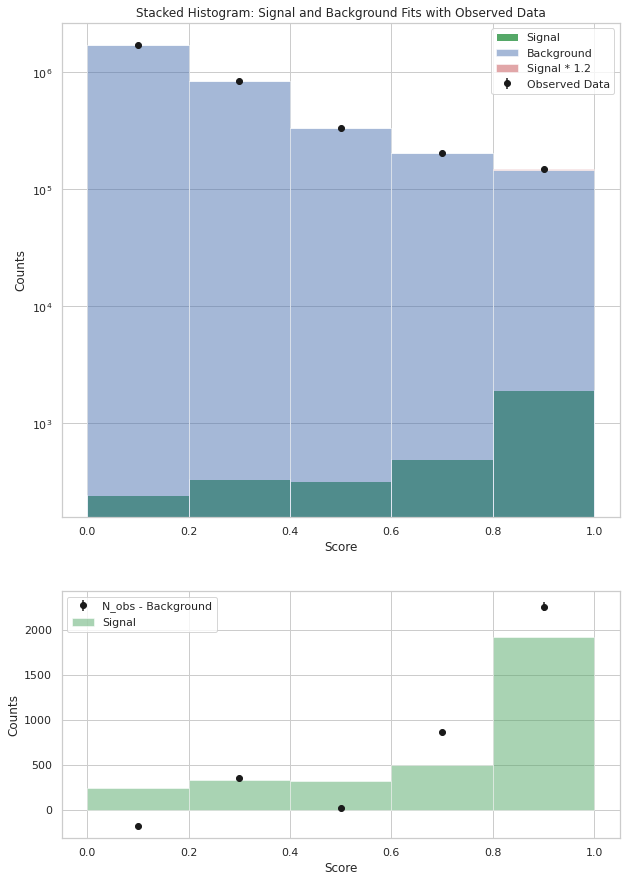

Validation Results:
---------- Results:
	mu_hat : 1.184128249478846
	delta_mu_hat : 0.38867764595975585
	p16 : 0.9897894264989682
	p84 : 1.378467072458724


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -4.127e+07                 │              Nfcn = 17               │
│ EDM = 1.47e-13 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────

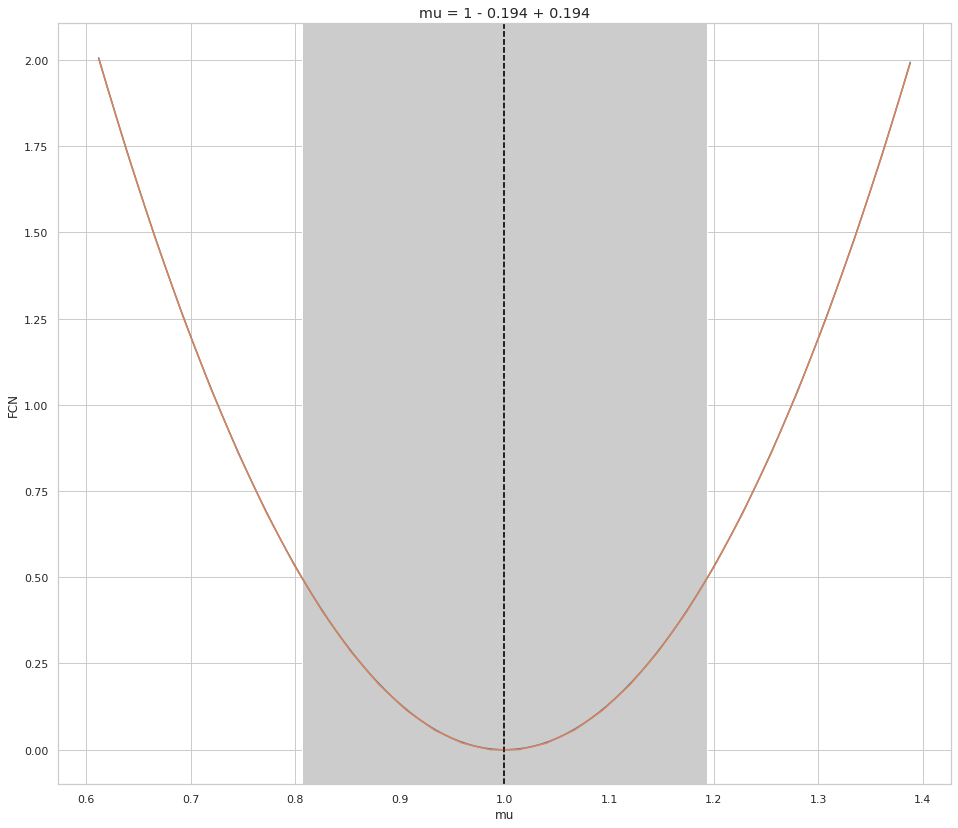

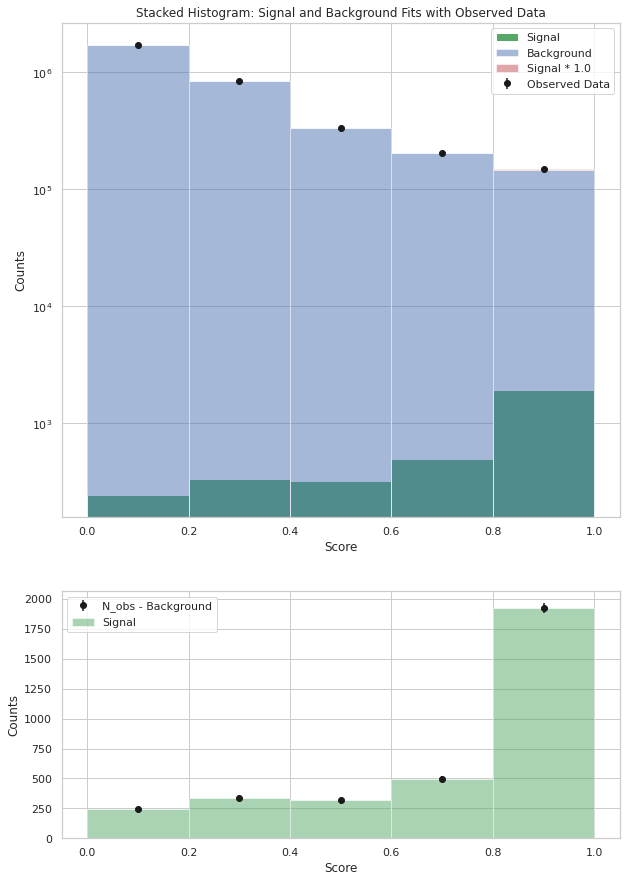

Holdout Results:
------- Results:
	mu_hat : 1.0
	delta_mu_hat : 0.38823829206461274
	p16 : 0.8058808539676936
	p84 : 1.1941191460323064




In [24]:

# fit submission
ingestion.fit_submission()

In [25]:

# load test set
data.load_test_set()

[*] Loading Test data


[+] Test data loaded successfully


In [26]:

# predict submission
ingestion.predict_submission(test_settings)

[*] Calling predict method of submitted model
[*] -> test weights sum =  3044146.0
Test Results:  {'mu_hat': -16.729492141716253, 'delta_mu_hat': 0.33278706365087085, 'p16': -16.895885673541688, 'p84': -16.56309860989082}
[*] - mu_hat: -16.729492141716253 - delta_mu_hat: 0.33278706365087085 - p16: -16.895885673541688 - p84: -16.56309860989082
[*] -> test weights sum =  3276179.0
Test Results:  {'mu_hat': 58.651811342258114, 'delta_mu_hat': 0.5183553798377891, 'p16': 58.39263365233922, 'p84': 58.91098903217701}
[*] - mu_hat: 58.651811342258114 - delta_mu_hat: 0.5183553798377891 - p16: 58.39263365233922 - p84: 58.91098903217701
[*] -> test weights sum =  3258237.0
Test Results:  {'mu_hat': 26.941766669209038, 'delta_mu_hat': 0.4525346168297257, 'p16': 26.715499360794176, 'p84': 27.1680339776239}
[*] - mu_hat: 26.941766669209038 - delta_mu_hat: 0.4525346168297257 - p16: 26.715499360794176 - p84: 27.1680339776239
[*] -> test weights sum =  3261136.0
Test Results:  {'mu_hat': 27.00150186933

In [27]:
ingestion.compute_result()

[*] Saving ingestion result


In [28]:

# save result
ingestion.save_result(output_dir)

***
# Score
***
1. Compute Scores
2. Visualize Scores


In [29]:
def visualize_scatter(ingestion_result_dict, ground_truth_mus):
    plt.figure(figsize=(6, 4))
    for key in ingestion_result_dict.keys():
        ingestion_result = ingestion_result_dict[key]
        mu_hat = np.mean(ingestion_result["mu_hats"])
        mu = ground_truth_mus[key]
        plt.scatter(mu, mu_hat, c='b', marker='o')
    
    plt.xlabel('Ground Truth $\mu$')
    plt.ylabel('Predicted $\mu$ (averaged for 100 test sets)')
    plt.title('Ground Truth vs. Predicted $\mu$ Values')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

def visualize_coverage(ingestion_result_dict, ground_truth_mus):

    for key in ingestion_result_dict.keys():
        plt.figure( figsize=(5, 5))

        ingestion_result = ingestion_result_dict[key]
        mu = ground_truth_mus[key]
        mu_hats = np.mean(ingestion_result["mu_hats"])
        p16s = ingestion_result["p16"]
        p84s = ingestion_result["p84"]
        
        # plot horizontal lines from p16 to p84
        for i, (p16, p84) in enumerate(zip(p16s, p84s)):
            plt.hlines(y=i, xmin=p16, xmax=p84, colors='b', label='p16-p84')

        plt.vlines(x=mu_hats, ymin=0, ymax=len(p16s), colors='r', linestyles='dashed', label='Predicted $\mu$')
        plt.vlines(x=mu, ymin=0, ymax=len(p16s), colors='g', linestyles='dashed', label='Ground Truth $\mu$')
        plt.xlabel('mu')
        plt.ylabel('pseudo-experiments')
        plt.title(f'mu distribution - Set_{key}')
        plt.legend()
        
    plt.show()


In [30]:
from score import Scoring

In [31]:
# Initialize Score
score = Scoring()

In [32]:
score.load_ingestion_results(output_dir)

[*] Reading predictions
[✔]


[*] Computing scores
------------------


Set 0
------------------
MAE (avg): 69.74790554103542
RMSE (avg): 1674.0417841235474
Interval: 0.4733088492119215
Coverage: 0.0
Quantiles Score: 0.7458659301543652
------------------
Set 1
------------------
MAE (avg): 20.654740050211416
RMSE (avg): 153.1207693190107
Interval: 0.3531470547411928
Coverage: 0.0
Quantiles Score: 1.0380123845300044
------------------
Set 2
------------------
MAE (avg): 34.30810679837203
RMSE (avg): 366.24622328985225
Interval: 0.4069931629080994
Coverage: 0.0
Quantiles Score: 0.8964742035932622
------------------
Set 3
------------------
MAE (avg): 41.65208121611173
RMSE (avg): 454.8549820967211
Interval: 0.3957698179351965
Coverage: 0.0
Quantiles Score: 0.9243683114324762
------------------
Set 4
------------------
MAE (avg): 38.89998887734583
RMSE (avg): 454.12291006659285
Interval: 0.3619705001419735
Coverage: 0.0
Quantiles Score: 1.0134030561428222


Overall Score
[*] --- RMSE: 620.477
[*] --- MAE: 41.053
[*] --- Interval: 0.398
[*] --- Coverage: 0.0
[

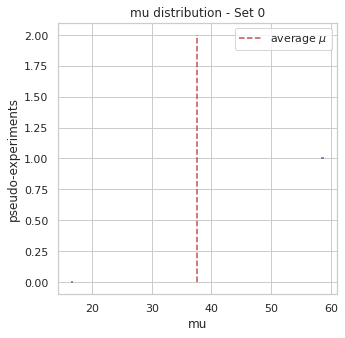

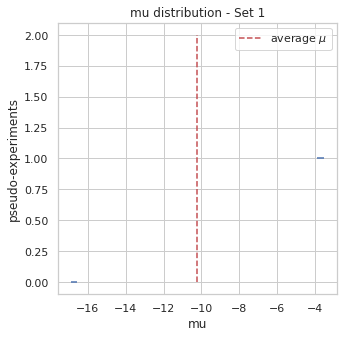

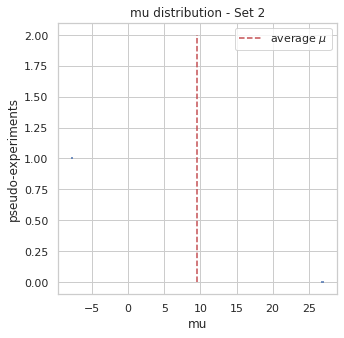

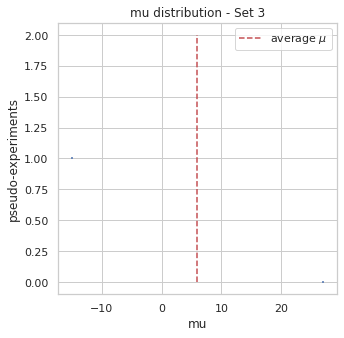

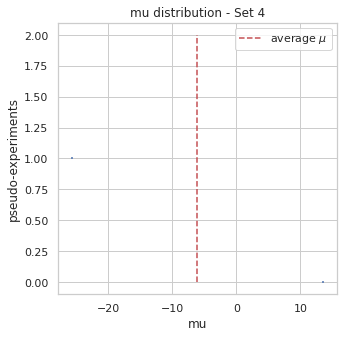

In [33]:
# Compute Score
score.compute_scores(test_settings)

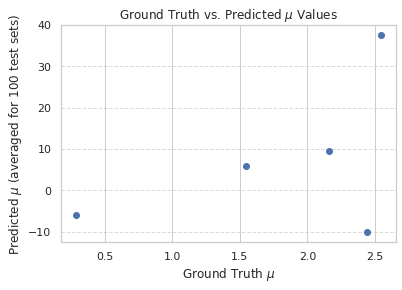

In [34]:
# Visualize scatter plot of ground truth mu and predicted mu
visualize_scatter(ingestion_result_dict=ingestion.results_dict, 
                  ground_truth_mus=test_settings["ground_truth_mus"])

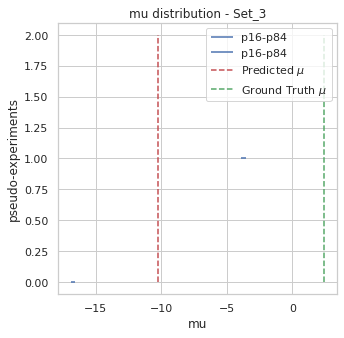

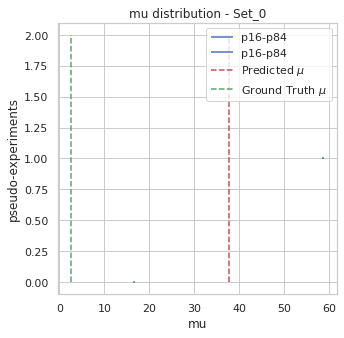

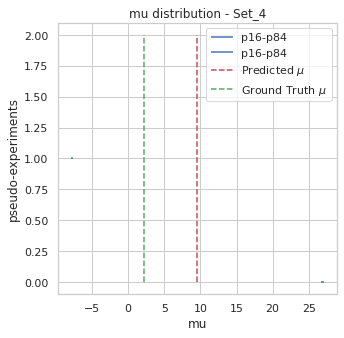

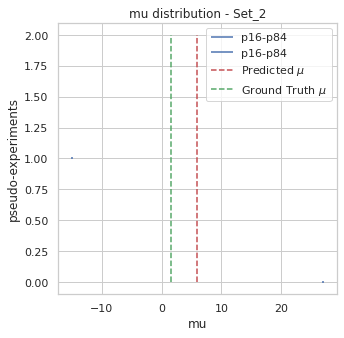

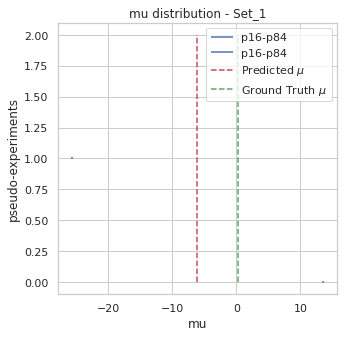

In [35]:
# Visualize coverage
visualize_coverage(ingestion_result_dict=ingestion.results_dict, 
                  ground_truth_mus=test_settings["ground_truth_mus"])

***
# Submission
***

### **Prepare the submission**

In [36]:
import datetime
from data_io import zipdir
the_date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")
code_submission = 'HiggsML-code_submission_' + the_date + '.zip'
zipdir(code_submission, submission_dir)
print("Submit : " + code_submission + " to the competition")
print("You can find the zip file in `HEP-Challenge/")

Submit : HiggsML-code_submission_24-08-06-16-57.zip to the competition
You can find the zip file in `HEP-Challenge/
